# Prediction of Data Usage

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as un_randfloat
from time import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense

### Load data from excel sheet

In [2]:
fileIFlix = 'iflix users profiling - 15934.xlsx'
# Load spreadsheet
iflix = pd.ExcelFile(fileIFlix)
iflixUser = iflix.parse('Sheet1')
iflixUserOriginal = iflixUser

### Data preprocessing for the predction

In [20]:
columns = ['DISTRICT_NAME', 'CONTACT_GENDER','DEVICE_CATEGORY','GEOGRAPHY','AGE','DATA_USAGE']
iflixUser = iflixUser[columns]

iflixUser['DATA_USAGE'] = iflixUser['DATA_USAGE'].fillna(iflixUser['DATA_USAGE'].mean())
iflixUser['DATA_USAGE'] = iflixUser['DATA_USAGE'].apply(lambda x:iflixUser['DATA_USAGE'].mean() if x<=0 else x )

min_max_scaler = preprocessing.MinMaxScaler()
# Create an object to transform the data to fit minmax processor
y_scaled = min_max_scaler.fit_transform(iflixUser[['DATA_USAGE']])
df_normalized = pd.DataFrame(y_scaled)
iflixUser['DATA_USAGE'] = df_normalized.iloc[:,0]

iflixUser['AGE'] = pd.to_numeric(iflixUser['AGE'],errors='coerce')
iflixUser = iflixUser.apply(lambda x:x.fillna(x.value_counts().index[0]))
iflixUser['GEOGRAPHY'] = iflixUser['GEOGRAPHY'].replace({'null':iflixUser['GEOGRAPHY'].mode()[0]})
iflixUser['DISTRICT_NAME'] = iflixUser['DISTRICT_NAME'].replace({'null':iflixUser['DISTRICT_NAME'].mode()[0]})
iflixUser['CONTACT_GENDER'] = iflixUser['CONTACT_GENDER'].replace({'null':iflixUser['CONTACT_GENDER'].mode()[0]})
iflixUser['DEVICE_CATEGORY'] = iflixUser['DEVICE_CATEGORY'].replace({'null':iflixUser['DEVICE_CATEGORY'].mode()[0]})


iflixUser.DISTRICT_NAME = iflixUser.DISTRICT_NAME.astype(str)
iflixUser.CONTACT_GENDER = iflixUser.CONTACT_GENDER.astype(str)
iflixUser.DEVICE_CATEGORY = iflixUser.DEVICE_CATEGORY.astype(str)
iflixUser.GEOGRAPHY = iflixUser.GEOGRAPHY.astype(str)

### Generate the correlation of features

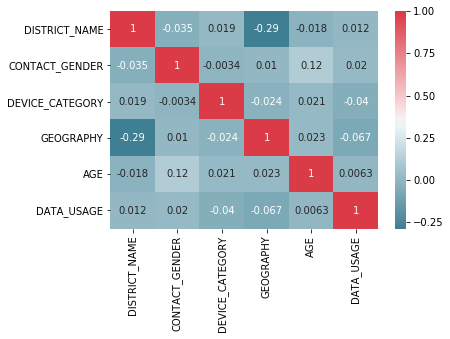

In [21]:
corr = iflixUser.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)


In [22]:
#make age groups for age column
iflixUser['AGE_GROUP'] = list(pd.cut(iflixUser['AGE'], [0, 18, 25, 30, 40, np.Infinity], right = True, labels = ['0-18', '18-25','25-30','30-40','40 or Above'], precision = 0, include_lowest = True))
iflixUser.AGE_GROUP = iflixUser.AGE_GROUP.astype(str)


# remove outliers by Data usage
Q1 = iflixUser['DATA_USAGE'].quantile(0.25)
Q3 = iflixUser['DATA_USAGE'].quantile(0.75)
IQR = Q3 - Q1
iflixUser_filtered = iflixUser[~((iflixUser['DATA_USAGE'] < (Q1 - 1.5 * IQR)) |(iflixUser['DATA_USAGE'] > (Q3 + 1.5 * IQR)))].reset_index(drop=True)



### One-hot Encoding for categorical features

In [23]:
dummy_columns = ['AGE_GROUP','DISTRICT_NAME', 'CONTACT_GENDER','DEVICE_CATEGORY','GEOGRAPHY']
iflixUser_filtered_for_regression = pd.get_dummies(iflixUser_filtered, prefix_sep='_', drop_first=True,columns = dummy_columns)



### Label Encoding for Categorical features

In [63]:
#iflixUser_filtered_ENCODED = pd.DataFrame()
#
#label_encoder_X_AGE_GROUP = LabelEncoder()
#label_encoder_X_DISTRICT_NAME= LabelEncoder()
#label_encoder_X_CONTACT_GENDER = LabelEncoder()
#label_encoder_X_DEVICE_CATEGORY = LabelEncoder()
#label_encoder_X_marital_GEOGRAPHY = LabelEncoder()

#label_encoder_X_AGE_GROUP  =label_encoder_X_AGE_GROUP.fit(iflixUser_filtered["AGE_GROUP"])
#label_encoder_X_DISTRICT_NAME  =label_encoder_X_DISTRICT_NAME.fit(iflixUser_filtered["DISTRICT_NAME"])
#label_encoder_X_CONTACT_GENDER  =label_encoder_X_CONTACT_GENDER.fit(iflixUser_filtered["CONTACT_GENDER"])
#label_encoder_X_DEVICE_CATEGORY =label_encoder_X_DEVICE_CATEGORY.fit(iflixUser_filtered["DEVICE_CATEGORY"])
#label_encoder_X_GEOGRAPHY  =label_encoder_X_marital_GEOGRAPHY.fit(iflixUser_filtered["GEOGRAPHY"])

#iflixUser_filtered_ENCODED["AGE_GROUP"] = label_encoder_X_AGE_GROUP.transform(iflixUser_filtered["AGE_GROUP"])
#iflixUser_filtered_ENCODED["DISTRICT_NAME"] = label_encoder_X_DISTRICT_NAME.transform(iflixUser_filtered["DISTRICT_NAME"])
#iflixUser_filtered_ENCODED["CONTACT_GENDER"] = label_encoder_X_CONTACT_GENDER.transform(iflixUser_filtered["CONTACT_GENDER"])
#iflixUser_filtered_ENCODED["DEVICE_CATEGORY"] = label_encoder_X_DEVICE_CATEGORY.transform(iflixUser_filtered["DEVICE_CATEGORY"])
#iflixUser_filtered_ENCODED["GEOGRAPHY"] = label_encoder_X_GEOGRAPHY.transform(iflixUser_filtered["GEOGRAPHY"])

#iflixUser_filtered_ENCODED["DATA_USAGE"] = list(iflixUser_filtered["DATA_USAGE"])

### Make Training and test data set for the regression model


In [24]:
X = iflixUser_filtered_for_regression[iflixUser_filtered_for_regression.columns[~iflixUser_filtered_for_regression.columns.isin(['DATA_USAGE'])]].values
Y = iflixUser_filtered_for_regression['DATA_USAGE'].values

#Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

### Use Linear Regression algorithm to build the model and test

In [25]:
lr =LinearRegression()

#linear regression parameters for hyper parameter optimization
lr_param_dist = {"lr__fit_intercept": [True, False],
              'lr__normalize':[True, False],
              "lr__copy_X":[True, False],
              'lr__n_jobs' : sp_randint(1,100),}

pipeline = Pipeline([
        ('lr', lr)
    ])
    
# run randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions=lr_param_dist,
                                   n_iter=100, error_score=0.0, random_state=0) 
random_search.fit(X_train, Y_train)
y_pred = random_search.best_estimator_.predict(X_test)
lr_r2_score = metrics.r2_score(Y_test,y_pred)


### Use Decision tree regression to build the model and test

In [14]:
dtr = tree.DecisionTreeRegressor()

# decision tree regression parameters for hyper parameter optimization
dtr_param_dist = {"dtr__max_features": ['auto', 'sqrt', 'log2'],
              "dtr__max_depth": sp_randint(1,100),
              "dtr__splitter": ['best', 'random'],              
              "dtr__min_impurity_decrease":un_randfloat(1.0, 10.0),
              "dtr__min_samples_split" : sp_randint(2,6),
              "dtr__min_samples_leaf": sp_randint(2,10),
              "dtr__criterion": ['mse', 'friedman_mse', 'mae']}

pipeline = Pipeline([
        ('dtr', dtr)
    ])
    
# run randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions=dtr_param_dist,
                                   n_iter=100, error_score=0.0, random_state=0) 
random_search.fit(X_train, Y_train)
y_pred = random_search.best_estimator_.predict(X_test)

dtr_r2_value = metrics.r2_score(Y_test,y_pred)

### Use Random forest regression to build the model and test

In [ ]:
rfr = RandomForestRegressor()

rfr_param_dist = {"rfr__max_features": sp_randint(2, 10),                  
                  "rfr__bootstrap": [True, False],
                  "rfr__n_estimators":sp_randint(160, 170),
                  "rfr__min_samples_split" : sp_randint(2,6),
                  "rfr__criterion": ["mse", "mae"]}

pipeline = Pipeline([
        ('rfr', rfr)
    ])
    
# run randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions= rfr_param_dist, n_iter=100, error_score=0.0, random_state=0) 
random_search.fit(X_train, Y_train)
y_pred = random_search.best_estimator_.predict(X_test)

rfr_r2_value = metrics.r2_score(Y_test,y_pred)

### Use SVM to build the model and test

In [ ]:
svm = SVR(kernel='linear')         
svm.fit(X_train, Y_train)
y_pred = svm.predict(X_test)

svm_r2_value = metrics.r2_score(Y_test,y_pred)

### User Neural network (Keras Sequential model) 

In [74]:
model = Sequential()

X = iflixUser_filtered_for_regression[iflixUser_filtered_for_regression.columns[~iflixUser_filtered_for_regression.columns.isin(['DATA_USAGE'])]]
input_dim = len(X.columns)
model.add(Dense(192, input_dim=input_dim, activation='relu', name="DenseLayer-1"))
model.add(Dense(64, activation='relu', name="DenseLayer-2"))
model.add(Dense(16, activation='relu', name="DenseLayer-3"))
model.add(Dense(1, activation='linear', name="DenseLayer-4"))
#print("Input Dimention: {}".format(input_dim))
#print(model.summary())

# compile the keras model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=1, validation_split=0.2)

y_pred = model.predict(X_test)
nn_r2_value = metrics.r2_score(Y_test, y_pred)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 23409 samples, validate on 5853 samples
Epoch 1/100
23409/23409 [==============================] - 3s 126us/step - loss: 3001.5450 - mean_absolute_error: 3001.5444 - val_loss: 2672.7921 - val_mean_absolute_error: 2672.7903
Epoch 2/100
23409/23409 [==============================] - 2s 106us/step - loss: 2643.0579 - mean_absolute_error: 2643.0610 - val_loss: 2636.8182 - val_mean_absolute_error: 2636.8191
Epoch 3/100
23409/23409 [==============================] - 2s 106us/step - loss: 2634.2635 - mean_absolute_error: 2634.2632 - val_loss: 2641.7001 - val_mean_absolute_error: 2641.7009
Epoch 4/100
23409/23409 [==============================] - 2s 105us/step - loss: 2632.7412 - mean_absolute_error: 2632.7390 - val_loss: 2637.7328 - val_mean_absolute_error: 2637.7334
Epoch 5/100
23409/23409 [==============================] - 2s 104us/step - loss: 2630.8542 - mean_a

23409/23409 [==============================] - 3s 134us/step - loss: 2624.7384 - mean_absolute_error: 2624.7395 - val_loss: 2636.4511 - val_mean_absolute_error: 2636.4529
Epoch 43/100
23409/23409 [==============================] - 4s 188us/step - loss: 2624.8526 - mean_absolute_error: 2624.8523 - val_loss: 2635.7367 - val_mean_absolute_error: 2635.7375
Epoch 44/100
23409/23409 [==============================] - 3s 119us/step - loss: 2623.2834 - mean_absolute_error: 2623.2812 - val_loss: 2632.2880 - val_mean_absolute_error: 2632.2883
Epoch 45/100
23409/23409 [==============================] - 5s 193us/step - loss: 2623.4686 - mean_absolute_error: 2623.4697 - val_loss: 2630.7559 - val_mean_absolute_error: 2630.7561
Epoch 46/100
23409/23409 [==============================] - 2s 104us/step - loss: 2623.9352 - mean_absolute_error: 2623.9368 - val_loss: 2630.1201 - val_mean_absolute_error: 2630.1206
Epoch 47/100
23409/23409 [==============================] - 4s 189us/step - loss: 2622.4954 -

23409/23409 [==============================] - 5s 196us/step - loss: 2608.1629 - mean_absolute_error: 2608.1648 - val_loss: 2638.7366 - val_mean_absolute_error: 2638.7378
Epoch 87/100
23409/23409 [==============================] - 2s 100us/step - loss: 2607.2037 - mean_absolute_error: 2607.2051 - val_loss: 2639.1378 - val_mean_absolute_error: 2639.1392
Epoch 88/100
23409/23409 [==============================] - 4s 190us/step - loss: 2607.0368 - mean_absolute_error: 2607.0356 - val_loss: 2645.5478 - val_mean_absolute_error: 2645.5496
Epoch 89/100
23409/23409 [==============================] - 3s 138us/step - loss: 2607.2068 - mean_absolute_error: 2607.2048 - val_loss: 2646.9296 - val_mean_absolute_error: 2646.9314
Epoch 90/100
23409/23409 [==============================] - 4s 187us/step - loss: 2606.7354 - mean_absolute_error: 2606.7356 - val_loss: 2645.7583 - val_mean_absolute_error: 2645.7583
Epoch 91/100
23409/23409 [==============================] - 3s 120us/step - loss: 2606.3367 -